In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
import io
import json
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

/Users/andipeng/miniforge3/envs/align-lang/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)
                
# helper mlp init function
def mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# MLP policy
class MLPPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)

# MLP policy
class CNNPolicy(nn.Module):
    def __init__(
        self, goal_dim, action_dim, hidden_size, output_mod=None):
        super().__init__()
        self.goal = mlp(goal_dim, hidden_size, hidden_dim=0, hidden_depth=0, output_mod=None) # => hidden_size
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=8,stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32,64,kernel_size=4,stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64,32,kernel_size=3,stride=1), nn.LeakyReLU(inplace=True), Flatten(), nn.BatchNorm1d(32), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, hidden_size) #(b_size,32*1*1)=>(b_size,hidden_size)
        )
        self.process = mlp(hidden_size*2, 1*36*36, hidden_dim=1000, hidden_depth=1, output_mod=nn.Sigmoid()) #(b_size,hidden_size*2)=>(b_size,32*1*1)
        self.mlptrunk = mlp(hidden_size*2, action_dim, hidden_dim=100, hidden_depth=1) #(b_size,hidden_size*2)=>(b_size,action_dim)
        self.apply(weight_init)

    def forward(self, goal, state):
        state = state/255.0 # process image + switch channels
        state = state.permute(0,3,1,2)
        state_embed = self.conv(state)
        goal_embed = self.goal(goal) # process goal
        goal_state = torch.cat((goal_embed,state_embed),dim=1) # process goal + state
        
        pred = self.mlptrunk(goal_state)
        return [pred]

In [3]:
# Goal-conditioned Point Maze (with multi state + color)
import gym
import gym.wrappers

class PointEnvGrid(gym.Env):
    def __init__(self):
        self.pos = np.array([99., 99.])
        self.obj1_pos = np.array([99., 99.])
        self.obj1_color = np.array([99., 99., 99., 99.])
        self.obj1_shape = np.array([99., 99., 99., 99.])
        self.obj2_pos = np.array([99., 99.])
        self.obj2_color = np.array([99., 99., 99., 99.])
        self.obj2_shape = np.array([99., 99., 99., 99.])
        self.goal = np.array(['go to the red X'])
        self.goal_pos = np.array([99., 99.])
        self.goal_color = np.array([99., 99., 99., 99.])
        self.goal_shape = np.array([99., 99., 99., 99.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    # creates test env with defined goal locations + colors
    def reset(self, agent_pos=[0,1,2,3], obj_pos=[0,1,2,3], obj_colors=[0,1,2,3], obj_shapes=[0,1,2,3], scalar=5, obstacle=False):
        # generates agent+objs without overlap
        agent_loc = np.random.choice(agent_pos)
        obj_pos = copy.deepcopy(obj_pos)
        if agent_loc in obj_pos:
            obj_pos.remove(agent_loc)
        self.pos = self.gen_pos(agent_loc, scalar)
        
        if len(obj_pos) == 1:
            self.obj1_pos = self.gen_pos(obj_pos[0], scalar)
            self.obj1_color = self.gen_color(obj_colors)
            self.obj1_shape = self.gen_shape(obj_shapes)
            
            self.goal_pos = self.obj1_pos
            self.goal_color = self.obj1_color
            self.goal_shape = self.obj1_shape
            if obstacle:
                self.obj2_pos = self.gen_pos(4, scalar)
                self.obj2_color = self.gen_color([1])
                self.obj2_shape = self.gen_shape([1])
        else:
            obj1_loc, obj2_loc = random.sample(obj_pos, 2)
            self.obj1_pos = self.gen_pos(obj1_loc, scalar)
            self.obj1_color = self.gen_color(obj_colors)
            self.obj1_shape = self.gen_shape(obj_shapes)
            self.obj2_pos = self.gen_pos(obj2_loc, scalar)
            self.obj2_color = self.gen_color(obj_colors)
            self.obj2_shape = self.gen_shape(obj_shapes)

            # choose goal from random in objects
            goal_obj = random.randint(1, 2)
            if goal_obj == 1:
                self.goal_pos = self.obj1_pos
                self.goal_color = self.obj1_color
                self.goal_shape = self.obj1_shape
            elif goal_obj == 2:
                self.goal_pos = self.obj2_pos
                self.goal_color = self.obj2_color
                self.goal_shape = self.obj2_shape
        self.goal = np.array(['go to the ' + get_color(self.goal_color) + ' ' + get_shape(self.goal_shape)])
        return self.get_full_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj1_shape, self.obj2_pos, self.obj2_color, self.obj2_shape, self.goal_color, self.goal_shape, self.goal]))
    
    def get_full_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj1_shape, self.obj2_pos, self.obj2_color, self.obj2_shape, self.goal_pos, self.goal_color, self.goal_shape]))
    
    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_full_obs(), reward, False, {}

    # given a range of areas, randomly selects and generates position
    def gen_pos(self, location, scalar):
        if location == 0:
            pos = np.array([-1.*scalar, 1.*scalar])
        elif location == 1:
            pos = np.array([1.*scalar, 1.*scalar])
        elif location == 2:
            pos = np.array([1.*scalar, -1.*scalar])
        elif location == 3:
            pos = np.array([-1.*scalar, -1.*scalar])
        elif location == 4:
            pos = np.array([-0.1*scalar, 0.2*scalar])
        return pos

    def gen_color(self, colors):
        one_hot_color = np.zeros(shape=4) # defines total number of colors to choose from
        rand_color = random.choice(colors) # samples color from range
        one_hot_color[rand_color] = 1.
        return one_hot_color

    def gen_shape(self, shapes):
        one_hot_shape = np.zeros(shape=4)
        rand_shape = random.choice(shapes)
        one_hot_shape[rand_shape] = 1.
        return one_hot_shape

def get_color(color):
    if color[0] == 1.:
        return 'red'
    elif color[1] == 1.:
        return 'green'
    elif color[2] == 1.:
        return 'blue'
    elif color[3] == 1.:
        return 'yellow'

def get_shape(shape):
    if shape[0] == 1.:
        return 'X'
    elif shape[1] == 1.:
        return 's'
    elif shape[2] == 1.:
        return '^'
    elif shape[3] == 1.:
        return 'd'

In [4]:
def plot_env(env, dist=False):
    fig = plt.figure(figsize=(5, 5),facecolor="black")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.axis('off')
    plt.scatter(env.pos[0],env.pos[1], marker='o', color='white', s=500) # plots agent
    if dist:
        plt.scatter(env.obj1_pos[0], env.obj1_pos[1], marker=get_shape(env.obj1_shape), color=get_color(env.obj1_color), s=500) # plots obj1
        plt.scatter(env.obj2_pos[0], env.obj2_pos[1], marker=get_shape(env.obj2_shape), color=get_color(env.obj2_color), s=500) # plots obj2
    else:
        plt.scatter(env.goal_pos[0], env.goal_pos[1], marker=get_shape(env.goal_shape), color=get_color(env.goal_color), s=1000) # plots goal
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    plt.close()
    return img

def plot_full_state(state, dist=False, hd=False):
    if not hd:
        fig = plt.figure(figsize=(.36, .36),facecolor="black")
        s = 10
    else:
        fig = plt.figure(figsize=(4, 4),facecolor="black")
        s = 400
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.axis('off')
    plt.scatter(state[0], state[1], marker='o', color='white', s=s) # plots agent
    if dist:
        plt.scatter(state[2], state[3], marker=get_shape(state[8:12]), color=get_color(state[4:8]), s=s) # plots obj1
        plt.scatter(state[12], state[13], marker=get_shape(state[18:22]), color=get_color(state[14:18]), s=s) # plots obj2
    else:
        plt.scatter(state[22], state[23], marker=get_shape(state[28:32]), color=get_color(state[24:28]), s=s) # plots goal
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    
    if hd:
        plt.savefig('state.pdf')  
    plt.close()
    return img

[-5.  5.  5. -5.  1.  0.  0.  0.  0.  0.  0.  1. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99.  5. -5.  1.  0.  0.  0.  0.  0.  0.  1.]
['go to the red d']


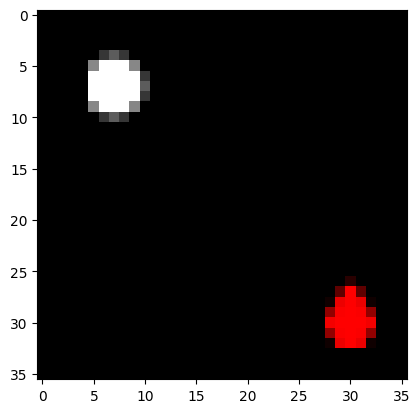

In [5]:
env = PointEnvGrid()
print(env.reset(agent_pos=[0], obj_pos=[2], obj_colors=[0], obj_shapes=[3], scalar=5, obstacle=False))
state = plot_full_state(env.get_full_obs(), dist=False)
print(env.goal)
plt.imshow(state)

In [6]:
# generates random trajs within specified constraints
def gen_trajs(env, num_trajs=1, agent_pos=[0,1,2,3], obj_pos=[0,1,2,3], obj_colors=[0,1,2,3], obj_shapes=[0,1,2,3], scalar=5, obstacle=False):
    trajs = []
    for traj in range(num_trajs):
        env.reset(agent_pos=agent_pos, obj_pos=obj_pos, obj_colors=obj_colors, obj_shapes=obj_shapes, scalar=scalar, obstacle=obstacle)
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [],'goal': []}
        delta_vector = env.goal_pos - env.pos
        obs = plot_full_state(env.get_full_obs())
        for i in range(20):
            act = delta_vector * 0.05 # Go in direction between start and end
            traj['obs'].append(obs.copy())
            traj['acts'].append(act.copy())
            one_hot_goal = np.concatenate([env.goal_color, env.goal_shape])
            traj['goal'].append(one_hot_goal)
            no, r, d, _ = env.step(act)
            obs = plot_full_state(no.copy())
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['goal'] = np.array(traj['goal'])
        #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        trajs.append(traj)
    return trajs

In [7]:
# colors = RGBY
# shapes = Xs^d (star, square, triangle, diamond)
env = PointEnvGrid()
trajs = gen_trajs(env, num_trajs=20, agent_pos=[0], obj_pos=[2], obj_colors=[0], obj_shapes=[0], scalar=5, obstacle=False)

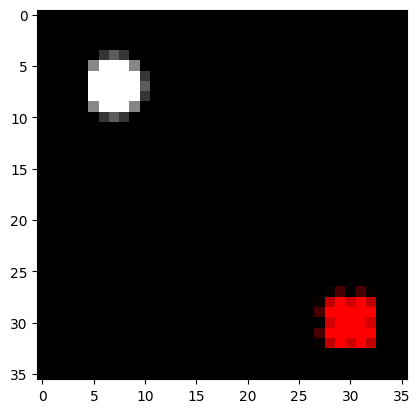

In [8]:
#import seaborn as sns
step = 0
traj = 0
plt.imshow(trajs[traj]['obs'][step])

In [9]:
num_tasks = len(trajs)

goal_size = 8 #384
env = PointEnvGrid()
act_size = env.action_space.shape[0]
hidden_size = 100

policy = CNNPolicy(goal_size, act_size, hidden_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

CNNPolicy(
  (goal): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
  )
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Flatten()
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=32, out_features=100, bias=True)
  )
  (process): Sequential(
    (0): Linear(in_features=200, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1296, bias=True)
    (3): Sigmoid()
  )
  (mlptrunk): Sequential(
    (0): Linea

[1,     1] loss: 0.79730690
[2,     1] loss: 0.54416132
[3,     1] loss: 0.24343929
[4,     1] loss: 0.17382410
[5,     1] loss: 0.25145656
[6,     1] loss: 0.22404099
[7,     1] loss: 0.15528473
[8,     1] loss: 0.16797991
[9,     1] loss: 0.19283839
[10,     1] loss: 0.10969007
[11,     1] loss: 0.15103467
[12,     1] loss: 0.11869528
[13,     1] loss: 0.13544631
[14,     1] loss: 0.12705801
[15,     1] loss: 0.08614924
[16,     1] loss: 0.09529148
[17,     1] loss: 0.08659668
[18,     1] loss: 0.09432866
[19,     1] loss: 0.06672303
[20,     1] loss: 0.12351599
[21,     1] loss: 0.10251687
[22,     1] loss: 0.10420395
[23,     1] loss: 0.12439883
[24,     1] loss: 0.14928290
[25,     1] loss: 0.12383467
[26,     1] loss: 0.08426422
[27,     1] loss: 0.12776209
[28,     1] loss: 0.15193306
[29,     1] loss: 0.18155271
[30,     1] loss: 0.11349579
[31,     1] loss: 0.07488715
[32,     1] loss: 0.17751414
[33,     1] loss: 0.10452680
[34,     1] loss: 0.16592553
[35,     1] loss: 0.107

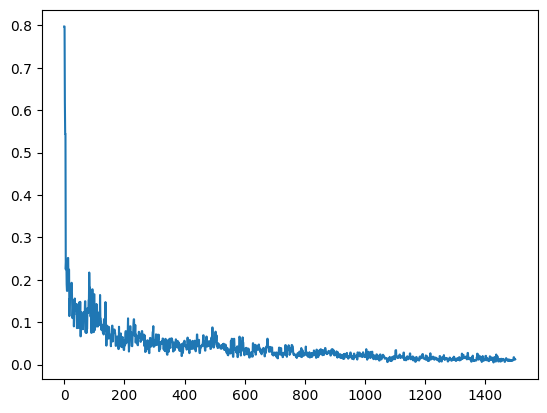

In [10]:
colors = sns.color_palette("hls", 10)
num_epochs = 500
batch_size = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        t_idx_pertraj = np.random.randint(20, size=(batch_size,)) # Indices of timesteps in traj
        t_states = np.concatenate([trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_goals = np.concatenate([trajs[c_idx]['goal'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
   
        t_states = torch.Tensor(t_states).float().to(device)
        t_goals = torch.Tensor(t_goals).float().to(device)
        #t_goals = torch.Tensor(lang_model.encode(t_goals.ravel())).float().to(device) # embeds goal through language model dim:384
        t_actions = torch.Tensor(t_actions).float().to(device)
        
        a_preds = policy(t_goals, t_states)[0]
        
        loss = torch.mean(torch.linalg.norm(a_preds - t_actions, dim=-1)) # supervised learning loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

['go to the green X']
Average dist to goal:  -6.543406656166782
Average std:  0.0


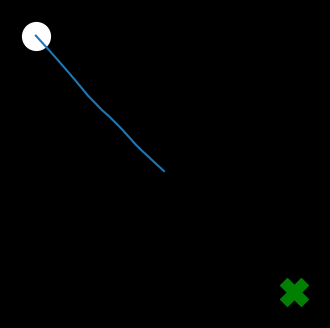

In [11]:
policy.eval()
num_test_trajs = 1
obstacle = False
# sets sampling for angles and colors
agent_pos=[0]
obj_pos=[2]
obj_colors=[1]
obj_shapes=[0]
scalar=5

dist_to_goals = []

for i in range(num_test_trajs):
    env.reset(agent_pos, obj_pos, obj_colors, obj_shapes, scalar, obstacle)
    one_hot_goal = np.concatenate([env.goal_color, env.goal_shape])
    goal = torch.Tensor(one_hot_goal[None]).to(device)
    #goal = torch.Tensor(lang_model.encode(env.goal)).to(device)
    obs = plot_full_state(env.get_full_obs())
    
    traj = {'obs': [],'acts': [], 'true_goal': [], 'agent_pos': []}
    for i in range(20):
        state = torch.Tensor(obs[None]).to(device)
        action = policy(goal,state)[0].cpu().detach().numpy()[0]
        traj['obs'].append(obs.copy())
        traj['acts'].append(action.copy())
        traj['true_goal'].append(env.goal)
        traj['agent_pos'].append(env.pos.tolist())
        no, r, d, _ = env.step(action)
        obs = plot_full_state(env.get_full_obs())
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['true_goal'] = np.array(traj['true_goal'])
    traj['agent_pos'] = np.array(traj['agent_pos'])
    dist_to_goals.append(r.copy())
    #print("Final dist to goal: ", r)
    
    fig = plt.figure(figsize=(4, 4),facecolor="black")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    colors = sns.color_palette("hls", 10)
    plt.scatter(traj['agent_pos'][0][0], traj['agent_pos'][0][1], marker='o', color='white', s=400) # plots obj1
    plt.scatter(env.obj1_pos[0], env.obj1_pos[1], marker=get_shape(env.obj1_shape), color=get_color(env.obj1_color), s=400) # plots obj1
    plt.scatter(env.obj2_pos[0], env.obj2_pos[1], marker=get_shape(env.obj2_shape), color=get_color(env.obj2_color), s=400) # plots obj1
    #plt.scatter(env.goal_pos[0], env.goal_pos[1], marker='X', color=get_color(env.goal_color), s=1000) # plots goal
    plt.plot(traj['agent_pos'][:, 0], traj['agent_pos'][:, 1]) # plots trajs
    plt.axis('off')
print(env.goal)
print("Average dist to goal: ", np.mean(dist_to_goals))
print("Average std: ", np.std(dist_to_goals))

In [12]:
import sys
np.set_printoptions(threshold=sys.maxsize)

[-5.  5.  5. -5.  0.  1.  0.  0.  0.  0.  0.  1. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99.  5. -5.  0.  1.  0.  0.  0.  0.  0.  1.]
['go to the green d']


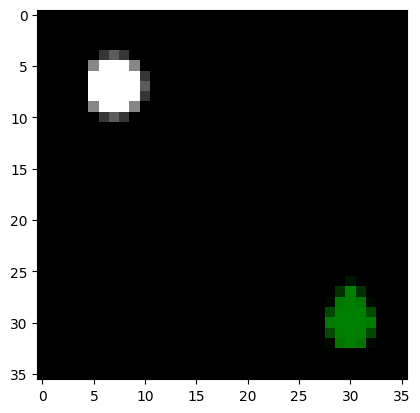

In [13]:
env = PointEnvGrid()
print(env.reset(agent_pos=[0], obj_pos=[2], obj_colors=[1], obj_shapes=[3], scalar=5, obstacle=False))
state = plot_full_state(env.get_full_obs(), dist=False)
print(env.goal)
plt.imshow(state)

In [ ]:
state